In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
batch_size = 8
depth = 256
num_keypoints = 256
training = True
num_heads = 2
num_layers = 2

In [22]:
from superglue.layers import SuperGlue
from superglue.losses import AugmentedSinkhornKnoppLayer, get_assignment_loss

In [5]:
model = SuperGlue(depth=depth, num_layers=num_layers, num_heads=num_heads)
optimal_assignment = AugmentedSinkhornKnoppLayer(lam=5, num_steps=100)

In [6]:
input_dA = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pA = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_dB = tf.keras.layers.Input(shape=[num_keypoints, depth])
input_pB = tf.keras.layers.Input(shape=[num_keypoints, 2])

input_pij_labels = tf.keras.layers.Input(shape=[num_keypoints+1, num_keypoints+1], dtype=tf.float32)

In [7]:
fA, fB = model(input_dA, input_pA, input_dB, input_pB, training=training)

In [8]:
model.summary()

Model: "super_glue"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keypoint_encoder_layer (Keyp (None, 256, 256)          111264    
_________________________________________________________________
attentional_message_passing_ (None, 256, 256)          659200    
_________________________________________________________________
attentional_message_passing_ (None, 256, 256)          659200    
_________________________________________________________________
attentional_message_passing_ (None, 256, 256)          659200    
_________________________________________________________________
attentional_message_passing_ (None, 256, 256)          659200    
_________________________________________________________________
dense_29 (Dense)             (None, 256, 256)          65792     
Total params: 2,813,856
Trainable params: 2,808,800
Non-trainable params: 5,056
__________________________________________

In [9]:
fA.shape, fB.shape

(TensorShape([None, 256, 256]), TensorShape([None, 256, 256]))

In [10]:
Pij, Sij = optimal_assignment(fA, fB)

In [11]:
Pij, Sij

(<tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity:0' shape=(None, 257, 257) dtype=float32>,
 <tf.Tensor 'augmented_sinkhorn_knopp_layer/Identity_1:0' shape=(None, 256, 256) dtype=float32>)

In [12]:
super_glue_model = tf.keras.models.Model(inputs=[input_dA, input_pA, input_dB, input_pB], outputs=Pij)

In [13]:
super_glue_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 2)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 2)]     0                                            
______________________________________________________________________________________________

In [14]:
from superglue.datasets import superpoint_image_pair_generator

image_size = (384, 384)

train_generator = superpoint_image_pair_generator(
    images_dir="/home/mkk/Downloads/superglue/images/",
    model_dir="/home/mkk/Downloads/superglue/model/sp_v5/",
    image_size=image_size,
    num_matches = num_keypoints
)

In [15]:
output_shapes = (
    (
        tf.TensorShape([num_keypoints, depth]),
        tf.TensorShape([num_keypoints, 2]),
        tf.TensorShape([num_keypoints, depth]),
        tf.TensorShape([num_keypoints, 2])
    ),
    (
        tf.TensorShape([num_keypoints+1, num_keypoints+1])
    )
)

dataset = tf.data.Dataset.from_generator(
    lambda: train_generator, ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32),
    output_shapes=output_shapes
)
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
dataset

<DatasetV1Adapter shapes: (((None, 256, 256), (None, 256, 2), (None, 256, 256), (None, 256, 2)), (None, 257, 257)), types: ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32)>

In [17]:
next(iter(dataset))

((<tf.Tensor: id=18407, shape=(8, 256, 256), dtype=float32, numpy=
  array([[[-0.01893366, -0.08492903,  0.09252884, ...,  0.05666865,
            0.08353902, -0.06351303],
          [-0.04269962, -0.0008825 ,  0.01518605, ..., -0.05591195,
           -0.09164416, -0.01933791],
          [ 0.01635636, -0.09350926, -0.00625832, ...,  0.04266833,
            0.01913879, -0.04743709],
          ...,
          [-0.12591323, -0.0123685 , -0.01377728, ..., -0.02395675,
            0.03337937, -0.01822404],
          [-0.10599068,  0.04002536,  0.03603951, ..., -0.08506081,
           -0.03237203, -0.00570867],
          [-0.04960947,  0.02480816, -0.09217245, ..., -0.0658787 ,
            0.00624092,  0.02061941]],
  
         [[-0.04019282, -0.08005668,  0.10472349, ...,  0.05318658,
            0.02758047, -0.03902478],
          [-0.02212866, -0.02551264, -0.05196945, ..., -0.02773394,
            0.09824826, -0.02891744],
          [-0.01066395,  0.00534597,  0.00826616, ..., -0.10167452

In [18]:
dataset

<DatasetV1Adapter shapes: (((None, 256, 256), (None, 256, 2), (None, 256, 256), (None, 256, 2)), (None, 257, 257)), types: ((tf.float32, tf.float32, tf.float32, tf.float32), tf.float32)>

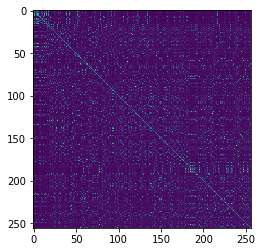

In [19]:
predicted_pij = super_glue_model.predict_generator(dataset, steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
super_glue_model.compile(optimizer=optimizer, loss=get_assignment_loss(1 / num_keypoints))

In [21]:
super_glue_model.fit(dataset, epochs=1, steps_per_epoch=5)

Train for 5 steps
5/5 [==============================] - 67s 13s/step - loss: 1223.0040


In [23]:
optimal_assignment.weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.00043617876>]

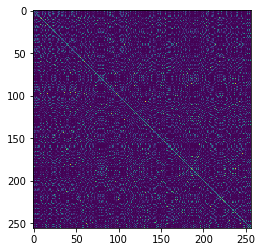

In [24]:
predicted_pij = super_glue_model.predict_generator(dataset, steps=1)
plt.imshow(predicted_pij[0][:-1, :-1])